# AIN 212 - Course Project - 2023-2024 Fall Semester
## Text Analysis

# THE STUDENT INFO
## Student Names: Süleyman Yolcu - Emirhan Utku
## Student IDs: 2210765016 - 2210765029

# Dataset: We will use the Women's E-Commerce Clothing Reviews Dataset available on Kaggle for the project.
https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews


*Content*
- Clothing ID: Integer Categorical variable that refers to the specific piece being reviewed.
- Age: Positive Integer variable of the reviewers age.
- Title: String variable for the title of the review.
- Review Text: String variable for the review body.
- Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
- Recommended IND: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
- Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.
- Division Name: Categorical name of the product high level division.
- Department Name: Categorical name of the product department name.
- Class Name: Categorical name of the product class name.

### Importing all the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/emirhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emirhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/emirhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/emirhan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Step 1: Data Collection

In [3]:
original = pd.read_csv("https://drive.google.com/uc?export=download&id=1s87qP0dN69JN0Ov7k82eG2JDObTdhnMt")

In [4]:
original.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


#### - The original dataset was too big , so we decided to take a subset preserving the distribution for the Recommend IND column

In [5]:
target_variable = 'Recommended IND'
subset_data, _ = train_test_split(original, train_size=5000, stratify=original[target_variable], random_state=42)
subset_data.to_csv('stratified_subset_dataset.csv', index=False)

In [6]:
path_to_dataset = 'stratified_subset_dataset.csv'
df = pd.read_csv(path_to_dataset)

# Step 2: Data Preprocessing and Cleaning

#### - The first column was redundant, so it is dropped.

In [7]:
df = df.drop("Unnamed: 0", axis=1)

#### - We could not impute the missing Title and Review text values because they were string , so we decided to drop it.

In [8]:
df.isnull().sum()

Clothing ID                  0
Age                          0
Title                      799
Review Text                182
Rating                       0
Recommended IND              0
Positive Feedback Count      0
Division Name                1
Department Name              1
Class Name                   1
dtype: int64

In [9]:
df.dropna(inplace=True)

*Lowercasing:*

- Convert all text to lowercase. This ensures consistency and avoids treating words with different cases as different entities.

In [10]:
df['Review Text'] = df['Review Text'].str.lower()

*Tokenization:*

- Split text into individual words or tokens. This is a crucial step to convert a sentence into a list of words.

In [11]:
df['Tokenized Text'] = df['Review Text'].apply(word_tokenize)

*Removing Stopwords:*

- Exclude common words (stopwords) that do not carry significant meaning. NLTK provides a list of stopwords.

In [12]:
stop_words = set(stopwords.words('english'))
df['Tokenized Text'] = df['Tokenized Text'].apply(lambda tokens: [word for word in tokens if word not in stop_words])


*Lemmatization:*

- Reduce words to their base or root form. This helps in reducing the dimensionality of the data and capturing the core meaning.

In [13]:
lemmatizer = WordNetLemmatizer()
df['Tokenized Text'] = df['Tokenized Text'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])


*Removing Special Characters:*

- Eliminate non-alphanumeric characters, punctuation, and other symbols.

In [14]:
df['Tokenized Text'] = df['Tokenized Text'].apply(lambda tokens: [re.sub(r'[^a-zA-Z0-9]', '', word) for word in tokens])


*Label Encoding:*
- Label encoding assigns a unique numerical label to each category.

In [15]:
label_encoder = LabelEncoder()
df['Division Name'] = label_encoder.fit_transform(df['Division Name'])
df['Department Name'] = label_encoder.fit_transform(df['Department Name'])
df['Class Name'] = label_encoder.fit_transform(df['Class Name'])

*Normalization or scaling of numeric features is crucial to ensure that features with different scales contribute equally to our  model. Min-Max scaling transforms features to a specific range, usually between 0 and 1.*

In [16]:
scaler = MinMaxScaler()
df[['Age', 'Rating']] = scaler.fit_transform(df[['Age', 'Rating']])

*Sentiment Analysis:*
- Method: Calculate sentiment scores using TextBlob.
- Rationale: Sentiment analysis can provide additional information about the reviews, and it's a useful feature for both clustering and classification. Positive or negative sentiment might be relevant to predicting the 'Recommend IND' variable.

In [17]:
from textblob import TextBlob
df['Sentiment Score'] = df['Review Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

*Bag of Words (BoW):*
- Method: Utilize CountVectorizer to transform the 'Tokenized Text' into a Bag-of-Words (BoW) representation.
- Rationale: This approach represents each document as a vector of word frequencies, disregarding the order of words. While effective for tasks like Naive Bayes classification, it may not capture nuanced meanings. For k-means clustering, the lack of word order information can impact cluster quality. Consider using TF-IDF vectorization for tasks where word importance is crucial, as it assigns weights based on term frequency and document frequency. Adjust the 'max_features' parameter in CountVectorizer to control the number of features in the BoW representation.

In [18]:
# Combine the tokens back into strings
df['Tokenized Text'] = df['Tokenized Text'].apply(lambda tokens: ' '.join(tokens))


# Exploratory Data Analysis (EDA)

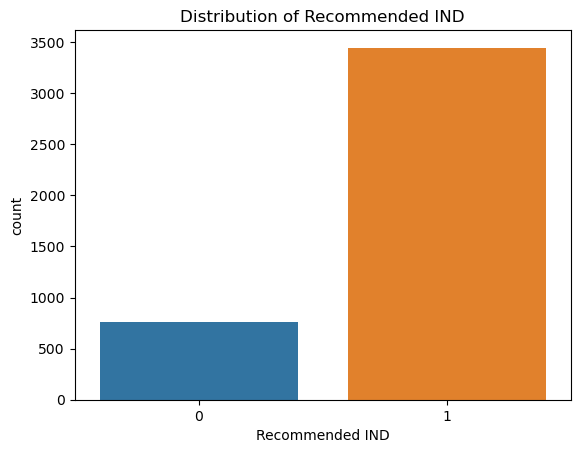

In [19]:
sns.countplot(x='Recommended IND', data=df)
plt.title('Distribution of Recommended IND')
plt.show()

- **Most of the customers have recommended the product they reviewed.**

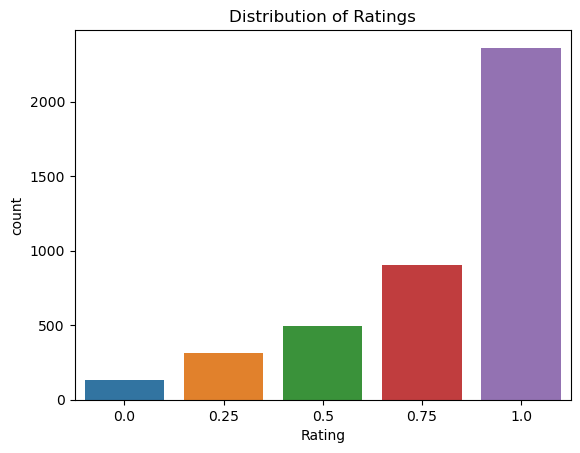

In [20]:
sns.countplot(x='Rating', data=df)
plt.title('Distribution of Ratings')
plt.show()

- **Since the number of recommenders is high, the ratings are concentrated in high scores.**

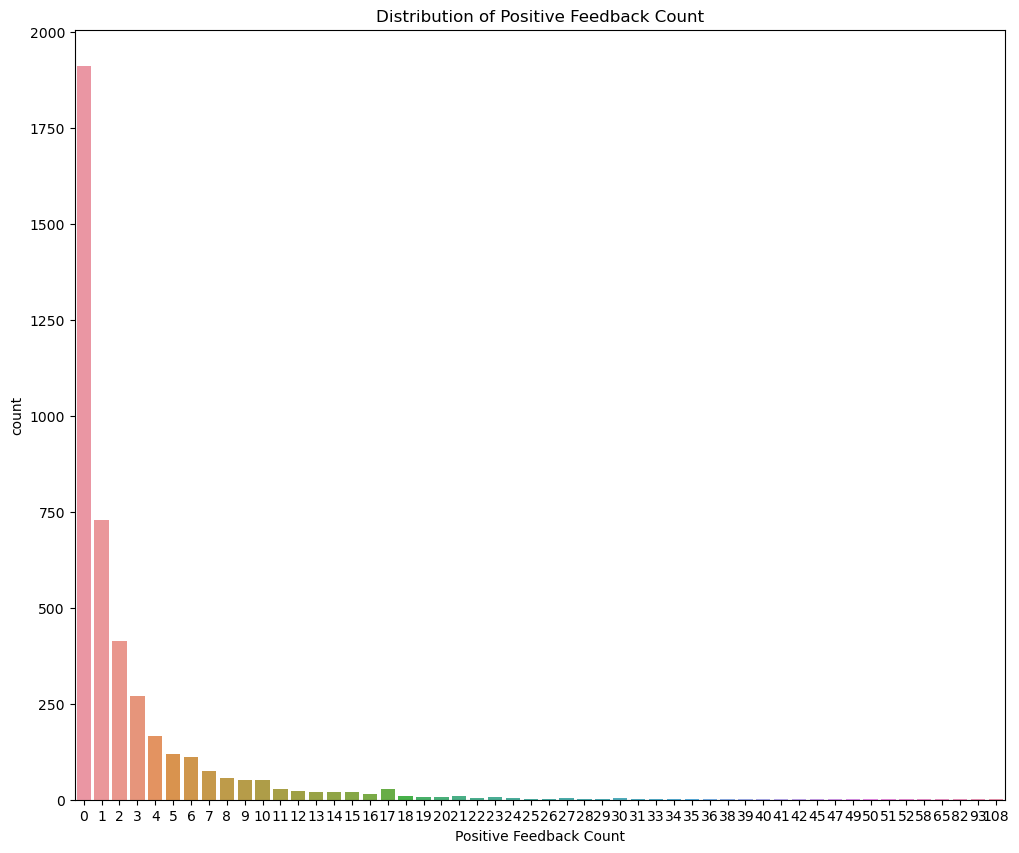

In [21]:
plt.figure(figsize=(12, 10))
sns.countplot(x='Positive Feedback Count', data=df)
plt.title('Distribution of Positive Feedback Count')
plt.show()

- **When we examine the data set according to Positive Feedback Count, we see that most people have not recommended any items before.**

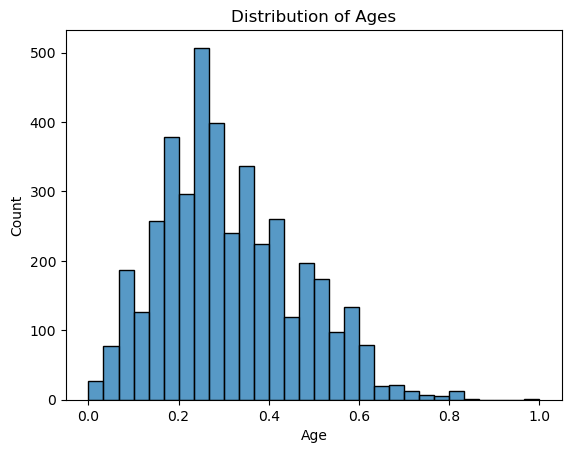

In [22]:
sns.histplot(x='Age', data=df, bins=30)
plt.title('Distribution of Ages')
plt.show()

- **We have a dataset with a high concentration of middle and young ages.**

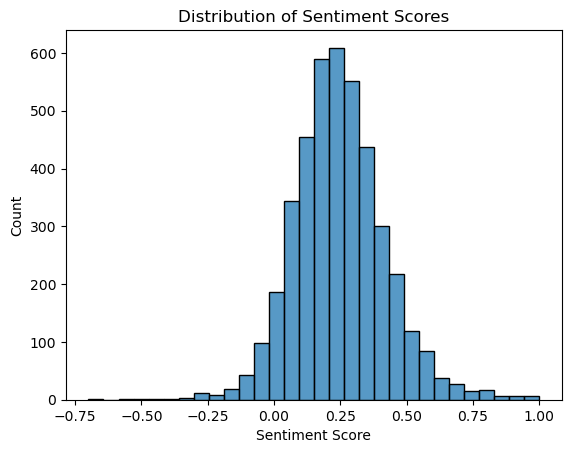

In [23]:
sns.histplot(x='Sentiment Score', data=df, bins=30)
plt.title('Distribution of Sentiment Scores')
plt.show()

- **Sentiment score has normal distribution and its mode is 0.25 .**

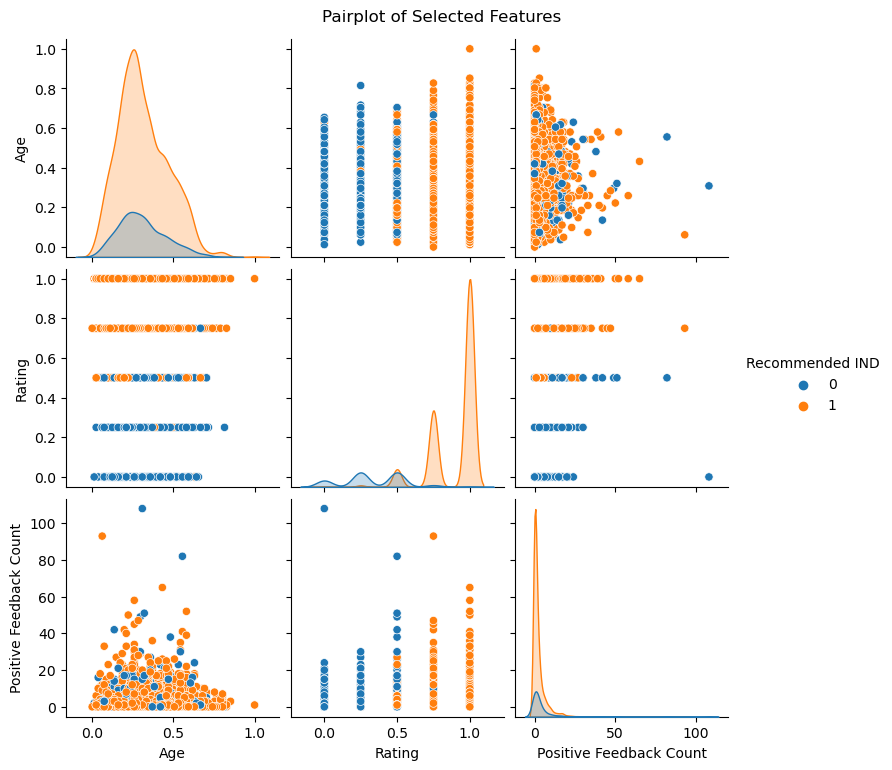

In [24]:
pairplot = sns.pairplot(df[['Age', 'Rating', 'Positive Feedback Count', 'Recommended IND']], hue='Recommended IND')
pairplot.fig.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()


- **If we make a general comment here, we see that it is recommended in most cases where the rating is higher than average.**

- **There is no clear correlation between age and whether it is recommended or not.**

In [25]:
df.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name', 'Tokenized Text', 'Sentiment Score'],
      dtype='object')

### Clustering Analysis


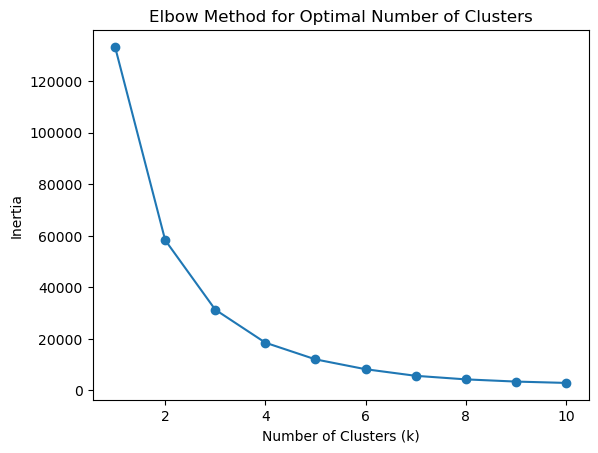

In [26]:
selected_features = ['Age' , 'Positive Feedback Count','Sentiment Score']
inertia = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df[selected_features])
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

- **Look for the "elbow" point in the plot, where the inertia starts to decrease at a slower rate. This is a subjective process.**
- **The optimal k is often considered to be the point where the rate of decrease sharply changes, resembling an elbow.**
- **In the example plot, the elbow point is around k=4. Therefore, k=4 is considered the optimal number of clusters.**

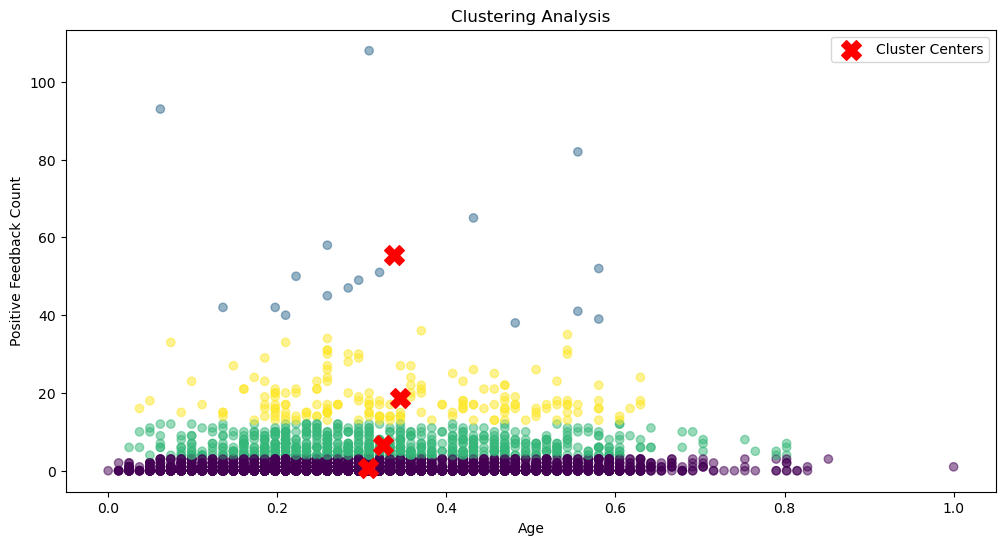

In [27]:
selected_features = ['Age', 'Positive Feedback Count', 'Sentiment Score']

optimal_clusters = 4 
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[selected_features])

feature1, feature2 = 'Age', 'Positive Feedback Count'
plt.figure(figsize=(12, 6))
plt.scatter(df[feature1], df[feature2], c=df['Cluster'], cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, selected_features.index(feature1)], 
            kmeans.cluster_centers_[:, selected_features.index(feature2)], 
            marker='X', s=200, c='red', label='Cluster Centers')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title('Clustering Analysis')
plt.legend()
plt.show()


- **The Elbow method was employed to determine the optimal number of clusters, and it suggested that four clusters could effectively capture the variance in the data.**
- **Age and Positive Feedback Count generally exhibit a smooth distribution. Positive Feedback Count is predominantly concentrated between 0 and 40. However, there is also an observable presence of counts exceeding 40 in the middle age range, indicating the need for our fourth cluster**

# Step 4: Predictive Modelling

### K-Nearest Neighbors (KNN) Classifier:

In [28]:
X = df[['Age', 'Rating', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name', 'Sentiment Score', 'Tokenized Text']]
y = df['Recommended IND']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'Tokenized Text'),  # TfidfVectorizer for text
        ('numeric', StandardScaler(), ['Age', 'Rating', 'Positive Feedback Count', 'Sentiment Score'])  # StandardScaler for numeric features
    ],
    remainder='passthrough'
)
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=3))  # Using the best number of neighbors obtained previously
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)
print("K-Nearest Neighbors Classifier Accuracy on Test Set:", accuracy)
print("K-Nearest Neighbors Classifier Classification Report on Test Set:\n", classification_report_result)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Adjust the number of splits as needed
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
print("\nCross-Validation Accuracy Scores:")
print(cv_scores)
print("Mean Accuracy:", cv_scores.mean())




K-Nearest Neighbors Classifier Accuracy on Test Set: 0.9333333333333333
K-Nearest Neighbors Classifier Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.81      0.78      0.80       106
           1       0.96      0.96      0.96       524

    accuracy                           0.93       630
   macro avg       0.89      0.87      0.88       630
weighted avg       0.93      0.93      0.93       630


Cross-Validation Accuracy Scores:
[0.92380952 0.91666667 0.94166667 0.92261905 0.91904762]
Mean Accuracy: 0.9247619047619049


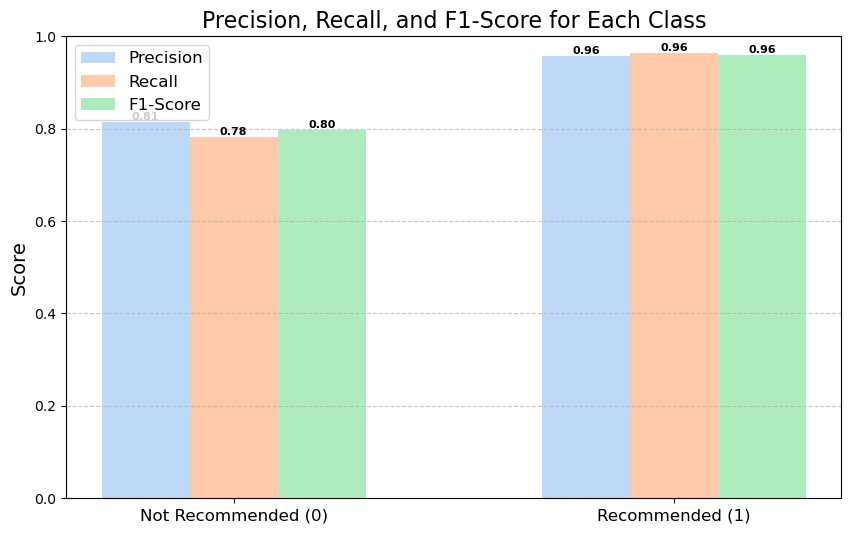

In [29]:
classification_report_dict = classification_report(y_test, y_pred, output_dict=True)
precision_values = [classification_report_dict[str(i)]['precision'] for i in range(2)]
recall_values = [classification_report_dict[str(i)]['recall'] for i in range(2)]
f1_values = [classification_report_dict[str(i)]['f1-score'] for i in range(2)]
sns.set_palette("pastel")
classes = ['Not Recommended (0)', 'Recommended (1)']
width = 0.2
x = np.arange(len(classes))
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width, precision_values, width, label='Precision', alpha=0.7)
bar2 = ax.bar(x, recall_values, width, label='Recall', alpha=0.7)
bar3 = ax.bar(x + width, f1_values, width, label='F1-Score', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(classes, fontsize=12)
ax.set_ylim([0, 1])  
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Precision, Recall, and F1-Score for Each Class', fontsize=16)
ax.legend(fontsize=12, loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.7)
for bars in [bar1, bar2, bar3]:
    for bar in bars:
        yval = bar.get_height()
        ax.annotate(f'{yval:.2f}', (bar.get_x() + bar.get_width() / 2, yval),
                    ha='center', va='bottom', fontsize=8, color='black', weight='bold')
plt.show()

### Algorithm Selection:
- **The chosen algorithm is KNN, implemented using the KNeighborsClassifier from scikit-learn. KNN is a reasonable choice for classification tasks, especially when dealing with a moderate-sized dataset.**

### Training Environment Setup:
- **The data is split into training, validation, and test sets to properly evaluate the model's performance. The training set is used to train the model, the validation set is used for hyperparameter tuning, and the test set is used for final evaluation.**

### Comments:
- **The code is structured using scikit-learn's pipeline, making it modular and easy to understand.**
- **Feature preprocessing is handled by a ColumnTransformer, allowing different preprocessing steps for text and numeric features.**
- **The model is trained, evaluated on a test set, and further validated using cross-validation, providing a comprehensive performance assessment.**




## K-Nearest Neighbors (KNN) Classifier Results Analysis

### Classifier Accuracy on Test Set:
- **Accuracy on the test set:** 93.33%
  - *Indicates that the model is performing well in terms of overall correctness.*

### Precision, Recall, and F1-Score:
#### Class 0 (Not Recommended):
- **Precision:** 81%
- **Recall:** 78%
- **F1-Score:** 80%
- **Support:** 106

#### Class 1 (Recommended):
- **Precision:** 96%
- **Recall:** 96%
- **F1-Score:** 96%
- **Support:** 524

*The precision, recall, and F1-score for both classes are high, suggesting that the model is effective at distinguishing between recommended (Class 1) and not recommended (Class 0) instances. The improvements in precision and recall for Class 0 compared to the previous results are notable.*

### Macro and Weighted Averages:
- **Macro Average F1-Score:** 88%
- **Weighted Average F1-Score:** 93%

*These scores suggest a good overall balance between precision and recall across both classes.*

### Cross-Validation Accuracy:
- **Cross-validation accuracy:**
  - *Range: 91.9% to 94.2% across different folds*
  - *Mean accuracy: 92.5%*
  - *Demonstrates that the model's performance is consistent across different subsets of the data, providing a more robust estimate of its generalization capabilities.*

### Analysis:
- *The model appears to be well-tuned and generalizes effectively to unseen data, as indicated by both the high test set accuracy and the consistent cross-validation performance.*
- *Precision, recall, and F1-score values provide insights into the model's ability to correctly identify instances of each class.*


### K-Nearest Neighbors (KNN) Classifier Evaluation:

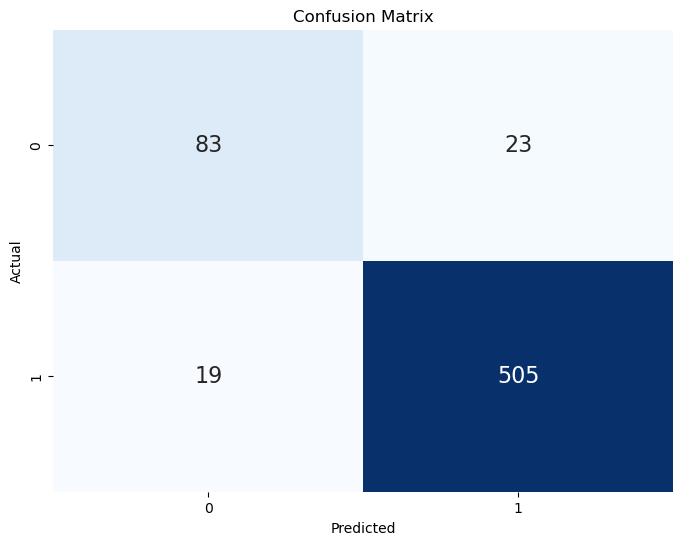

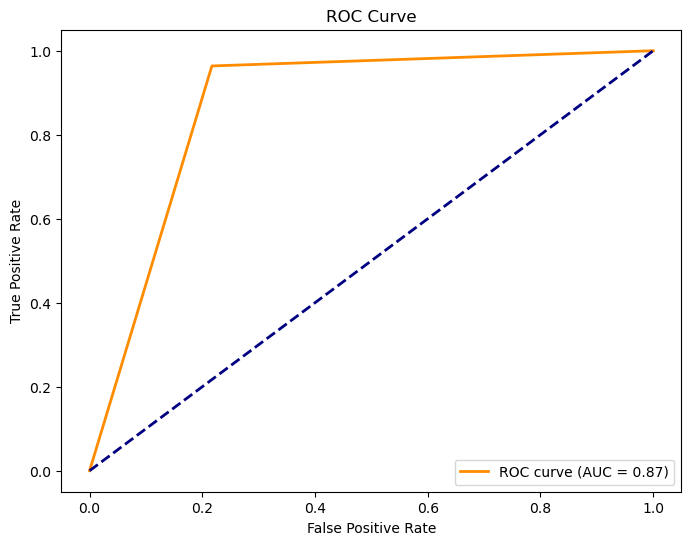

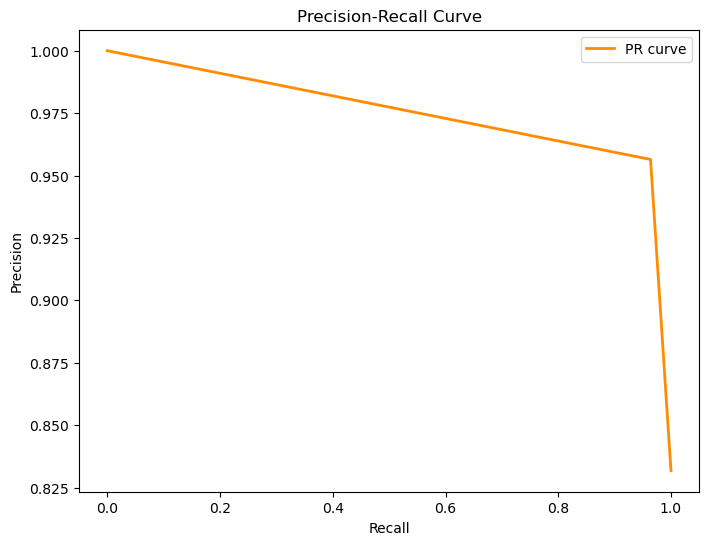

In [30]:
conf_matrix = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16}, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_pred)


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

#### -The AUC value represents the area under the curve. High AUC values indicate that the model is performing well. The model performs well as the model has high AUC values

#### -High precision and low recall describe a situation where a classification model's positive predictions are often accurate, but at the same time, it misses some of the positive examples. In other words, the model correctly identifies most of the instances it predicts as positive, but it overlooks some instances that are actually positive. This indicates that the model is quite selective and only labels instances as positive when it is highly confident.

### Naive Bayes Classifier:

In [31]:
X_text = df['Tokenized Text']
X_rating = df[['Rating']]
y = df['Recommended IND']


vectorizer = CountVectorizer()
X_text_counts = vectorizer.fit_transform(X_text)


X_combined = hstack([X_text_counts, X_rating])


X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)


multinomial_nb_classifier = MultinomialNB()


multinomial_nb_classifier.fit(X_train, y_train)

y_pred_multinomial_nb = multinomial_nb_classifier.predict(X_test)


accuracy_multinomial_nb = accuracy_score(y_test, y_pred_multinomial_nb)
classification_report_multinomial_nb = classification_report(y_test, y_pred_multinomial_nb)


print("Multinomial Naive Bayes Classifier Accuracy on Test Set:", accuracy_multinomial_nb)
print("Multinomial Naive Bayes Classifier Classification Report on Test Set:\n", classification_report_multinomial_nb)


Multinomial Naive Bayes Classifier Accuracy on Test Set: 0.873015873015873
Multinomial Naive Bayes Classifier Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.75      0.44      0.56       226
           1       0.89      0.97      0.93      1034

    accuracy                           0.87      1260
   macro avg       0.82      0.70      0.74      1260
weighted avg       0.86      0.87      0.86      1260



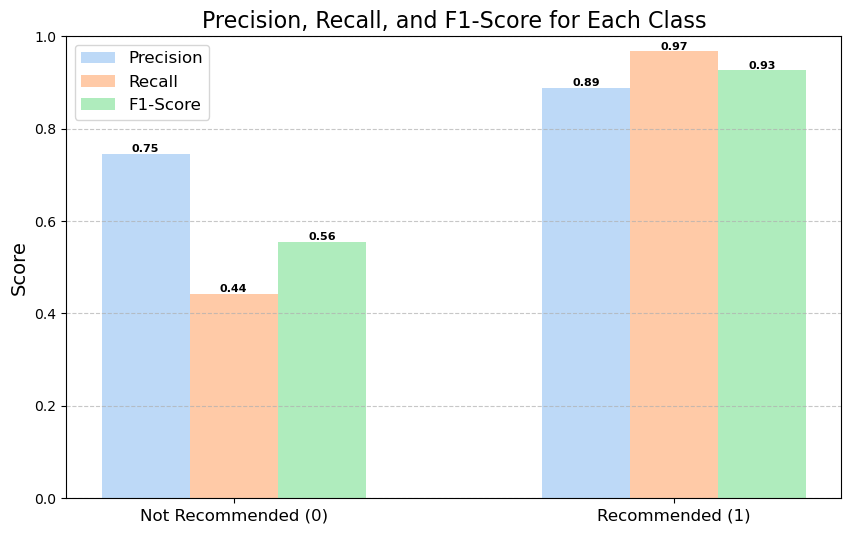

In [32]:
classification_report_dict = classification_report(y_test, y_pred_multinomial_nb, output_dict=True)


precision_values = [classification_report_dict[str(i)]['precision'] for i in range(2)]
recall_values = [classification_report_dict[str(i)]['recall'] for i in range(2)]
f1_values = [classification_report_dict[str(i)]['f1-score'] for i in range(2)]


sns.set_palette("pastel")
classes = ['Not Recommended (0)', 'Recommended (1)']
width = 0.2
x = np.arange(len(classes))


fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width, precision_values, width, label='Precision', alpha=0.7)
bar2 = ax.bar(x, recall_values, width, label='Recall', alpha=0.7)
bar3 = ax.bar(x + width, f1_values, width, label='F1-Score', alpha=0.7)


ax.set_xticks(x)
ax.set_xticklabels(classes, fontsize=12)
ax.set_ylim([0, 1])  
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Precision, Recall, and F1-Score for Each Class', fontsize=16)
ax.legend(fontsize=12, loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.7)


for bars in [bar1, bar2, bar3]:
    for bar in bars:
        yval = bar.get_height()
        ax.annotate(f'{yval:.2f}', (bar.get_x() + bar.get_width() / 2, yval),
                    ha='center', va='bottom', fontsize=8, color='black', weight='bold')


plt.show()


## Algorithm Selection:

- **Chosen Algorithm:** Multinomial Naive Bayes (MultinomialNB)
  - *A suitable choice for text classification tasks with discrete features, such as word frequencies.*
  - *Known for its simplicity and efficiency in handling high-dimensional data.*

## Training Environment Setup:

- **Data Split:** Split into training and test sets.
- **Classifier:** Multinomial Naive Bayes
- *The classifier has been trained on the training set and evaluated on the test set.*
- *This setup allows for a proper assessment of the model's performance.*

## Comments:

- **Accuracy on Test Set:** 87.30%
  - *Indicates that the model is performing reasonably well in terms of overall correctness.*

- *Precision, recall, and F1-score are reported for each class (0 and 1), providing insights into the model's ability to correctly identify instances of each class.*

- *The precision-recall trade-off is evident, especially for class 0, where precision is lower than recall. This suggests that while the model correctly identifies many not recommended instances, there is a higher chance of false positives.*
itives.

## Naive Bayes Classifier Results Analysis

### Precision, Recall, and F1-Score:

#### Class 0 (Not Recommended):
- **Precision:** 75%
- **Recall:** 44%
- **F1-Score:** 56%
- **Support:** 226

#### Class 1 (Recommended):
- **Precision:** 89%
- **Recall:** 97%
- **F1-Score:** 93%
- **Support:** 1034

*The precision, recall, and F1-score values provide a detailed understanding of the model's performance for each class. Class 1 (Recommended) shows higher precision, recall, and F1-score compared to Class 0 (Not Recommended).*


### Macro and Weighted Averages:

- **Macro Average F1-Score:** 74%
- **Weighted Average F1-Score:** 86%

*These scores offer an overall evaluation of the model's performance across both classes.*


### Analysis:

- *The Multinomial Naive Bayes classifier performs well in identifying recommended instances (Class 1), with high precision, recall, and F1-score for this class.*
- *For not recommended instances (Class 0), the model has a lower precision, indicating room for improvement in reducing false positives.*
- *Consideration could be given to further feature engineering or exploring other classifiers to improve precision for Class 0 without compromising recall for Class 1.*
- *Overall, the model provides a reasonable baseline, and further iterations can focus on refining features and exploring different algorithms to achieve desired performance metrics.*
rformance metrics.

### Naive Bayes Classifier Evaluation:

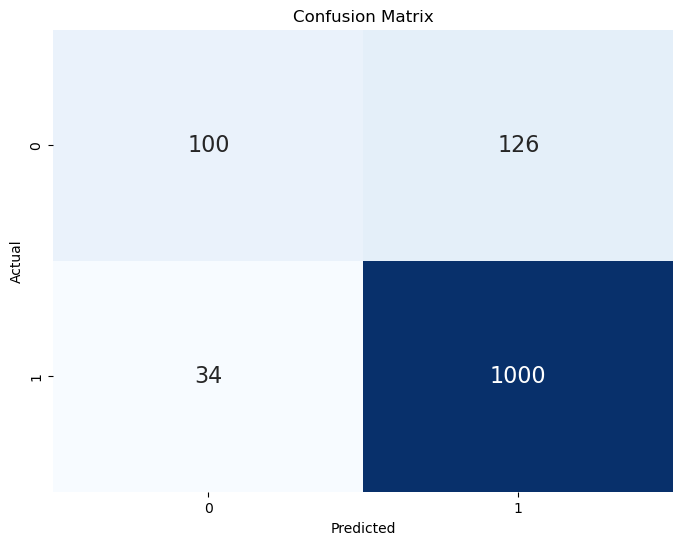

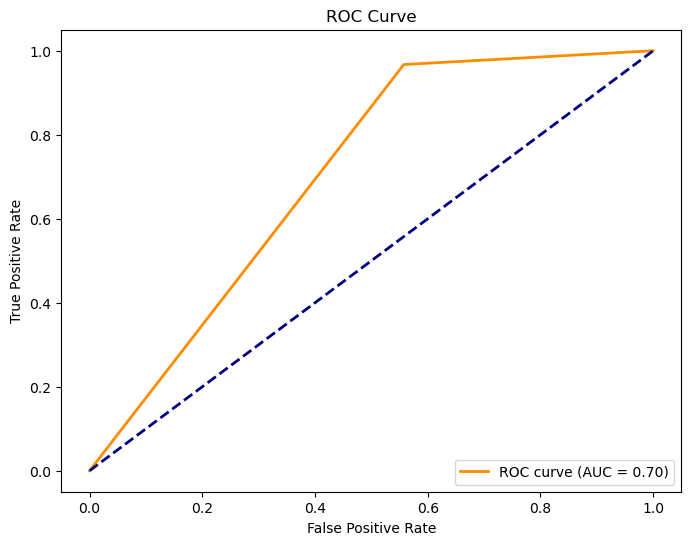

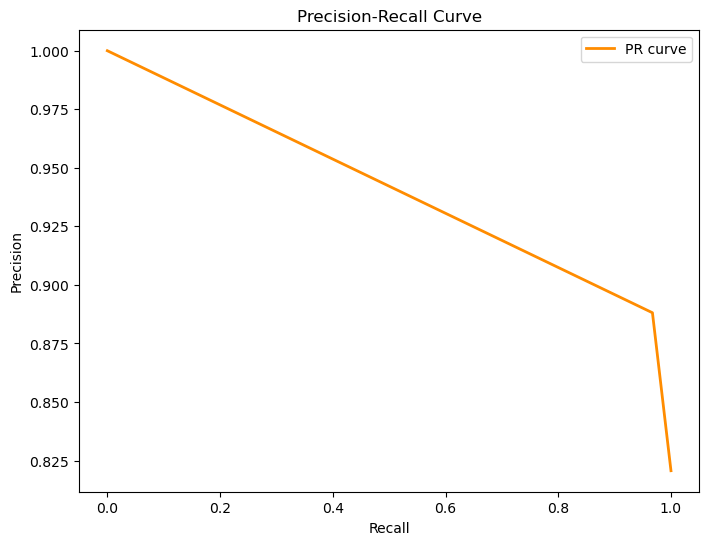

In [33]:

conf_matrix = confusion_matrix(y_test, y_pred_multinomial_nb)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16}, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


fpr, tpr, _ = roc_curve(y_test, y_pred_multinomial_nb)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_pred_multinomial_nb)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()


#### -The Bayes classifier has a lower AUC value compared to the K-Nearest Neighbors (KNN) classifier evaluation. Nevertheless, it still exhibits a considerably high AUC value, indicating that the model performs well, despite the lower AUC when compared to the KNN classifier.

#### -When the average precision is low across various recall levels, it implies that the model is struggling to make precise positive predictions consistently as it adjusts the decision threshold

### General Comment About Classifiers:

- **The choice of classifiers reflects a thoughtful consideration of the dataset characteristics and the nature of the classification problem.**
- **KNN is selected for its adaptability to mixed feature types and its ability to capture complex relationships in the data.**
- **Multinomial Naive Bayes is chosen specifically for its strength in handling text data and its efficiency in high-dimensional spaces.**

## Conclusion
- **In conclusion, the analysis and modeling efforts conducted on the Women's E-Commerce Clothing Reviews dataset have provided valuable insights into customer reviews and recommendations. The comprehensive approach involved data collection, preprocessing, exploratory data analysis (EDA), clustering analysis, and predictive modeling using two distinct algorithms: K-Nearest Neighbors (KNN) Classifier and Multinomial Naive Bayes Classifier.**